In [ ]:
#| default_exp training

In [ ]:
#| hide
from nbdev.showdoc import *

# training
> This module will contain the TTSDataset and the collate function used in training

In [ ]:
#| export 
from fastspeech.data import *
import torch
from fastspeech.visualize import show_mel, plot_loss
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_value_
from tqdm.auto import tqdm
from torch import tensor
from pathlib import Path

In [ ]:
#| hide
from fastspeech.modules import *
from fastspeech.preprocess import ZScoreNormalization, MinMaxNormalization
from fastspeech.data import *
from torch.optim import Adam
from functools import partial
import torch.nn.functional as F

In [ ]:
#| export
def mae_loss(pred: tensor, target: tensor): 
    return torch.abs(target - pred).mean()

In [ ]:
mae_loss(tensor([1.,2,3]), tensor([2.,6.5,4]))

tensor(2.1667)

In [ ]:
#| export
class TransformerScheduler:
    def __init__(self, optimizer, lr_mul:float, d_model:int, n_warmup_steps:int):
        self._optimizer = optimizer
        self.lr_mul, self.d_model = lr_mul, d_model
        self.n_warmup_steps, self.n_steps = n_warmup_steps, 0

    def step(self):
        self._update_learning_rate()

    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))
    
    def _update_learning_rate(self):
        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [ ]:
#| export
class FastspeechLearner:
    def __init__(self, dl: DataLoader, norm, Model, Optimizer, Scheduler, 
                config: dict, loss_fn_a, loss_fn_b, loss_fn_c,
                 dl_v: DataLoader = None, accum_grad: int=1, 
                 grad_clip: float=1., fp_16: bool=False, log_interval: int=10, 
                 checkpoint_dir="../checkpoints", device=None):
        
        self.dl, self.norm, self.config = dl, norm, config
        self.dl_v = dl_v
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model = Model(config["model"], device=device).to(device)
        self.optim = Optimizer(self.model.parameters(), **config["optim"])
        self.scheduler = Scheduler(self.optim, **config["scheduler"])
        
        self.loss_fn_a, self.loss_fn_b = loss_fn_a, loss_fn_b
        self.loss_fn_c = loss_fn_c
        
        self.accum_grad, self.grad_clip = accum_grad, grad_clip
        self.fp_16, self.log_interval = fp_16, log_interval
        self.device, self.scaler = device, GradScaler(enabled=self.fp_16)
        
        self.save_num = 0
        self.mel_history = []
        self.loss_history = {
            "train": {"mels": [], "duration": [], "pitch": [], "energy": []},
            "valid": {"mels": [], "duration": [], "pitch": [], "energy": []}
        }
    
    def map_to_device(self, inp: list):
        return list(map(lambda x: x.to(self.device), inp))
    
    def process_batch(self, batch):
        phones, durations, pitch, energy, mels = self.map_to_device(batch)
        return phones, durations, pitch, energy, mels
        
    def compute_loss(self, phones, durations, pitch, energy, mels):
        d_slice = (slice(None), slice(None, -1))
        mel_pred, duration_pred, pitch_pred, energy_pred = self.model(phones, durations)
        loss_mel = self.loss_fn_a(mel_pred, mels)
        loss_dur =  self.loss_fn_b(duration_pred[d_slice], 
                                   durations[d_slice].squeeze())
        
        loss_pitch = self.loss_fn_b(pitch_pred, pitch)
        loss_energy = self.loss_fn_b(energy_pred, energy)
        
        return loss_mel, loss_dur, loss_pitch, loss_energy

    def one_step(self, inp: tuple):
        phones, durations, pitch, energy, mels = self.process_batch(inp)
        self.optim.zero_grad()
        
        with autocast(enabled=self.fp_16):
            loss_mel, loss_dur, loss_pitch, loss_energy = self.compute_loss(phones, durations, pitch, energy, mels)
            loss = loss_mel + loss_dur + loss_pitch + loss_energy
        
        self.scaler.scale(loss).backward()
        clip_grad_value_(self.model.parameters(), self.grad_clip)
        
        return loss_mel.detach(), loss_dur.detach(), loss_pitch.detach(), loss_energy.detach()
    
    def append_loss(self, loss_mel, loss_dur, loss_pitch, loss_energy, loss_set="train"):
        self.loss_history[loss_set]["mels"].append(loss_mel.cpu())
        self.loss_history[loss_set]["duration"].append(loss_dur.cpu())
        self.loss_history[loss_set]["pitch"].append(loss_pitch.cpu())
        self.loss_history[loss_set]["energy"].append(loss_energy.cpu())
    
    def compute_valid_loss(self):
        for batch in self.dl_v:
            phones, durations, pitch, energy, mels = self.process_batch(batch)
            with torch.no_grad():
                loss_mel, loss_dur, loss_pitch, loss_energy = self.compute_loss(phones, durations,
                                                                                pitch, energy, mels)
            self.append_loss(loss_mel, loss_dur, loss_pitch, loss_energy, "valid")
            
            
    def fit(self, steps: int):
        curr_steps = 0
        
        val_phone, val_duration, val_pitch, val_energy, val_mel = next(iter(self.dl))
        show_mel(self.norm.denormalize(val_mel)[0], "validation")
              
        progress_bar = tqdm(total=steps, desc="Training", unit="step")
        while curr_steps < steps:
            for batch in self.dl:
                if curr_steps > steps: break
                    
                loss_mel, loss_dur, loss_pitch, loss_energy = self.one_step(batch)
                
                if curr_steps % self.accum_grad == 0 or (curr_steps+1) == len(self.dl):
                    self.scaler.step(self.optim)
                    self.scaler.update()
                    self.scheduler.step()
                
                curr_steps += 1
                self.append_loss(loss_mel, loss_dur, loss_pitch, loss_energy, 'train')
                self._update_bar(progress_bar, loss_mel, loss_dur, loss_pitch, loss_energy)
                
                if curr_steps % self.log_interval == 0 or curr_steps == steps:
                    with torch.no_grad(): 
                        val_phone, val_duration, val_pitch, val_energy = self.map_to_device([val_phone, val_duration, 
                                                                                             val_pitch, val_energy])
                        pred_mel, _, _, _ = self.model(val_phone, val_duration, val_pitch, val_energy)
                        pred_mel = self.norm.denormalize(pred_mel).cpu()
                        
                    self.mel_history.append(pred_mel)
                    
                    loss_valid_text = ''
                    if self.dl_v:
                        self.compute_valid_loss()
                        avg_loss_valid = tensor(
                            self.loss_history['valid']["mels"][-len(self.dl_v):]).mean()
                        loss_valid_text = f", valid loss: {avg_loss_valid:.4f}"
                    
                    if not self.checkpoint_dir.exists():
                        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
                    save_path = self.checkpoint_dir/f"save_{self.save_num}.pt"
                    self.save_num += 1
                    self.save_model(save_path)
        
                    loss_slice = slice(-self.log_interval, None)
                    avg_loss = tensor(self.loss_history['train']["mels"][loss_slice]).mean()
                         
                    title = f"step: {curr_steps}, loss: {avg_loss:.4f}{loss_valid_text}"
                    show_mel(pred_mel[0], title)
                    
        progress_bar.close()
        
    def _update_bar(self, progress_bar, loss_mel, loss_dur, loss_pitch, loss_energy):
        progress_bar.update(1)
        loss_output = {"loss_mel": f"{loss_mel:.4f}", "loss_duration": f"{loss_dur:.2f}", 
                       "loss_pitch": f"{loss_pitch:.2f}", "loss_energy": f"{loss_energy:.2f}"}
        progress_bar.set_postfix(loss_output, refresh=True)
        
    def save_model(self, file_path):
        torch.save({
            "state_dict": {
                'model': self.model.state_dict(),
                'optim': self.optim.state_dict(),
            },
            "config": self.config,
            "norm": self.norm,
        }, file_path)
    
    def load_model_state_dict(self, sd: dict):
        self.model.load_state_dict(sd["model"])
        self.optim.load_state_dict(sd["optim"])

In [ ]:
#| hide
path = "../sample_data"
path_vocab = "../sample_data/cmudict-0.7b.symbols.txt"

ds = TTSDataset(path, path_vocab, ZScoreNormalization, preload=True, 
                stats={'max_val': 100., 'min_val': .01, "mean": 0.01,
                       "std": 0.20, "top_db": 35})

dl = DataLoader(ds, 2, collate_fn=partial(collate_fn, pad_num=ds.vocab.pad_num, 
                                          norm=ds.norm))

In [ ]:
hs, no = 32, 80
config = {
    "model": {
        "embedding_size": 85, "hidden_size": 32, "num_bins": 80, "num_encoders": 2, "num_decoders": 2,
        "encoder": {
            "hidden_size": 32,
            "multi_head_attention": {"hidden_size": 32, "num_attention_heads": 4, 
                                     "hidden_dropout_prob": 0.1},
            "conv_net": {"hidden_size": 32, "kernal_sizes": [3,3], "filter_size": 16,
                         "hidden_dropout_prob": 0.1}
        },
        "decoder": {
            "hidden_size": 32,
            "multi_head_attention": {"hidden_size": 32, "num_attention_heads": 4,
                                    "hidden_dropout_prob": 0.1},
            "conv_net": {"hidden_size": 32, "kernal_sizes": [3,3], "filter_size": 16,
                         "hidden_dropout_prob": 0.1}
        },
        "duration_predictor": {"hidden_size": 32, "kernal_sizes": [3,3], "filter_size": 16, "hidden_dropout_prob": 0.1},
        "pitch_predictor": {"hidden_size": 32, "kernal_sizes": [3,3], "filter_size": 16, "hidden_dropout_prob": 0.1},
        "energy_predictor": {"hidden_size": 32, "kernal_sizes": [3,3], "filter_size": 16, "hidden_dropout_prob": 0.1},
        "postnet": {"hidden_size": 80, "kernal_size": 3, "filter_size": 16, "hidden_dropout_prob": 0.1, "num_layers": 5},
    },
    "optim": {"lr":  1e-4, "betas": (0.9, 0.98), "eps": 1e-10, "weight_decay": 0},
    "scheduler": {"lr_mul": 1., "d_model": hs, "n_warmup_steps": 4000},
}

learner = FastspeechLearner(dl, ds.norm, FastSpeech2, Adam, TransformerScheduler, 
                            config, mae_loss, F.mse_loss, mae_loss, dl_v=dl, log_interval=5)

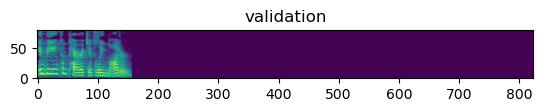

Training:   0%|          | 0/10 [00:00<?, ?step/s]

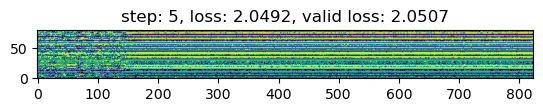

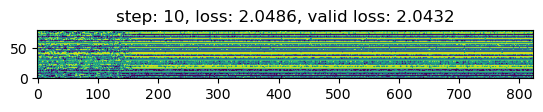

In [ ]:
learner.fit(10)

In [ ]:
file_path = "../checkpoints/save_2.pt"
learner.save_model(file_path)
!ls ../checkpoints/

save_0      save_1.pt   save_161.pt save_21.pt
save_0.pt   save_100.pt save_2.pt   save_590.pt


In [ ]:
#| export
def count_parameters(model: torch.nn.Module):
    return  sum([p.numel() for p in model.parameters() if p.requires_grad])

In [ ]:
count_parameters(learner.model)

61379

In [ ]:
#| export
def load_checkpoint(file_path: str, device='cpu'):
    checkpoint = torch.load(file_path, map_location=torch.device(device))
    return checkpoint["state_dict"], checkpoint["config"], checkpoint["norm"]

In [ ]:
state_dict, config, norm = load_checkpoint(file_path, 'cpu')
learner = FastspeechLearner(dl, norm, FastSpeech, Adam, TransformerScheduler,
                            config, mae_loss, F.mse_loss, mae_loss, log_interval=5)
learner.load_model_state_dict(state_dict)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()